In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import random

plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20
# plt.rcParams.keys()

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
def adjusted_r2(y_true, y_pred, n, p):
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

df = pd.read_csv('../../datasets/group_14.csv')
df["focus_factor"] = (
    df["focus_factor"]
    .astype(str)                  # ensure it's string
    .str.replace(",", ".", regex=False)  # replace comma with dot
)
df["focus_factor"] = pd.to_numeric(df["focus_factor"], errors="coerce")

In [3]:
# Encode categorical variable
df_encoded = pd.get_dummies(data=df, columns=["target_class"], drop_first=True)

# Define target and features
y = df_encoded['target_regression']
X = df_encoded.drop(columns=["target_regression"])


# Found on previous analysis
optimal_columns = ['artist_song_count', 'album_freq', 'artists_avg_popularity',
       'ambient_level', 'target_class_class_65', 'target_class_class_73']

dummy_cols = ['target_class_class_65', 'target_class_class_73']

numerical_columns = ['artist_song_count', 'album_freq', 'artists_avg_popularity',
       'ambient_level']





##  Evaluating Polynomial Regression Across Different Degrees
This step investigates how the **polynomial degree** affects model performance using the previously selected optimal features:
- Evaluate **polynomial degrees 2–6** using the selected features.
- For each degree, perform **10 train-test splits**, generate polynomial features, add dummy variables, and train a Linear Regression model.
- Compute **average MSE** and **R²** across runs.
- Plot **MSE** and **R²** vs. polynomial degree to identify the degree that balances **model complexity and performance**.

From the graphs, we can see that the most **optimal polynomial degree is 4**, as it achieves the **highest R²** and the **lowest MSE**.







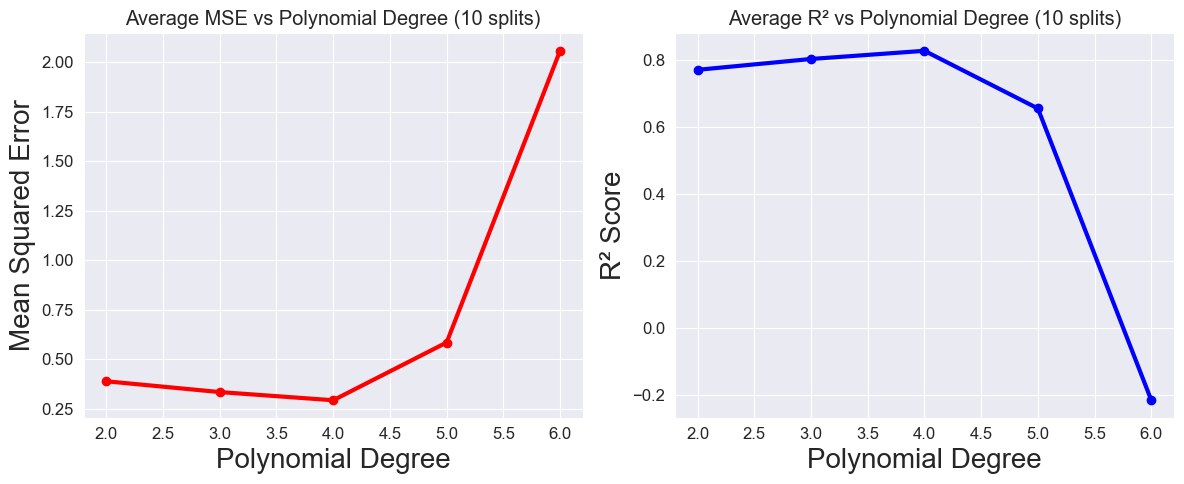

In [4]:
degree_range = range(2, 7)


degrees = []
mse_values = []
r2_values = []

for n in degree_range:
    # Temporary lists to collect metrics across 10 runs
    mse_temp = []
    r2_temp = []

    poly = PolynomialFeatures(degree=n, include_bias=False)

    for i in range(10):
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X[optimal_columns], y, test_size=0.2, random_state=i
        )

        # Separate dummy columns
        X_train_dummy = X.loc[X_train.index, dummy_cols]
        X_test_dummy = X.loc[X_test.index, dummy_cols]

        # Create polynomial features
        X_train_pr = poly.fit_transform(X_train[numerical_columns])
        X_test_pr = poly.transform(X_test[numerical_columns])

        # Convert to DataFrame with proper column names and indices
        X_train_pr = pd.DataFrame(
            X_train_pr,
            columns=poly.get_feature_names_out(numerical_columns),
            index=X_train.index
        )
        X_test_pr = pd.DataFrame(
            X_test_pr,
            columns=poly.get_feature_names_out(numerical_columns),
            index=X_test.index
        )

        # Combine polynomial features with dummy columns
        X_train_final = pd.concat([X_train_pr, X_train_dummy], axis=1)
        X_test_final = pd.concat([X_test_pr, X_test_dummy], axis=1)

        # Train and predict
        lr = LinearRegression()
        lr_model = lr.fit(X_train_final, y_train)
        y_pred = lr.predict(X_test_final)

        # Metrics for this run
        mse_temp.append(mean_squared_error(y_test, y_pred))
        r2_temp.append(r2_score(y_test, y_pred))

    # Average metrics across 10 runs for this polynomial degree
    degrees.append(n)
    mse_values.append(np.mean(mse_temp))
    r2_values.append(np.mean(r2_temp))

# === Plot results ===
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# MSE plot
axes[0].plot(degrees, mse_values, marker='o', color='red')
axes[0].set_title('Average MSE vs Polynomial Degree (10 splits)')
axes[0].set_xlabel('Polynomial Degree')
axes[0].set_ylabel('Mean Squared Error')
axes[0].grid(True)

# R² plot
axes[1].plot(degrees, r2_values, marker='o', color='blue')
axes[1].set_title('Average R² vs Polynomial Degree (10 splits)')
axes[1].set_xlabel('Polynomial Degree')
axes[1].set_ylabel('R² Score')
axes[1].grid(True)

plt.tight_layout()
plt.show()



Here, we fit the model using **polynomial degree 4**, perform **10 runs with unused random seeds**, and compute the **average metrics** to evaluate overall performance and confirm the accuracy suggested by the graphs.


In [68]:
mse_scores = []
r2_scores = []
poly = PolynomialFeatures(degree=4, include_bias=False)

for i in range(10):
    i = random.randint(20, 100)  # pick a random integer between 20 and 100
    X_train, X_test, y_train, y_test = train_test_split(
        X[optimal_columns], y, test_size=0.2, random_state=i
    )

    # Polynomial features (degree=4)
    X_train_pr = poly.fit_transform(X_train[numerical_columns])
    X_test_pr = poly.transform(X_test[numerical_columns])

    X_train_dummy = X.loc[X_train.index, dummy_cols]
    X_test_dummy = X.loc[X_test.index, dummy_cols]
    # Convert to DataFrames
    X_train_pr = pd.DataFrame(
        X_train_pr,
        columns=poly.get_feature_names_out(numerical_columns),
        index=X_train.index
    )
    X_test_pr = pd.DataFrame(
        X_test_pr,
        columns=poly.get_feature_names_out(numerical_columns),
        index=X_test.index
    )

    # Combine polynomial and dummy columns
    X_train_final = pd.concat([X_train_pr, X_train_dummy], axis=1)
    X_test_final = pd.concat([X_test_pr, X_test_dummy], axis=1)

    # Train model
    lr = LinearRegression()
    lr.fit(X_train_final, y_train)

    # Predict and evaluate
    y_pred = lr.predict(X_test_final)
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))

# === Average results ===
mse_avg = np.mean(mse_scores)
mse_std = np.std(mse_scores)
r2_avg = np.mean(r2_scores)
r2_std = np.std(r2_scores)

print(f"Final Polynomial Degree: 4")
print(f"Average MSE over 10 runs: {mse_avg:.4f} ± {mse_std:.4f}")
print(f"Average R² over 10 runs: {r2_avg:.4f} ± {r2_std:.4f}")

Final Polynomial Degree: 4
Average MSE over 10 runs: 0.2782 ± 0.0248
Average R² over 10 runs: 0.8381 ± 0.0126


Plot the model's predictions for **one unused random seed** to visually evaluate its performance on unseen data.







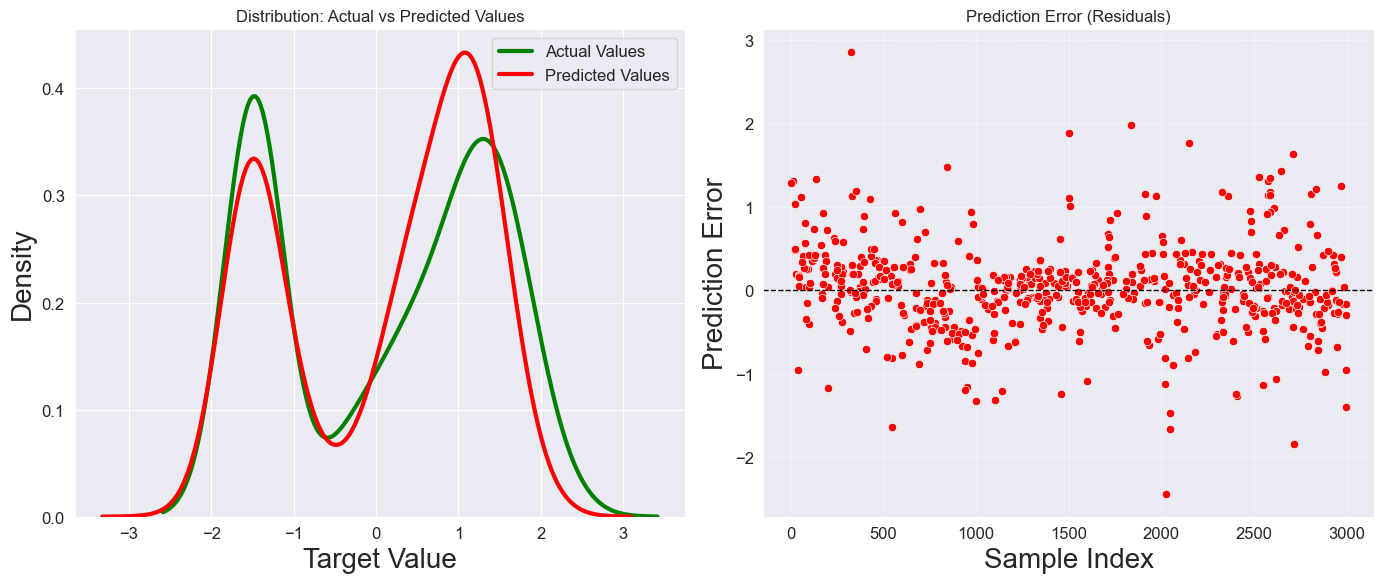

In [69]:
X_train, X_test, y_train, y_test = train_test_split(
        X[optimal_columns], y, test_size=0.2, random_state=11
    )

X_train_pr = poly.fit_transform(X_train[numerical_columns])
X_test_pr = poly.transform(X_test[numerical_columns])

X_train_dummy = X.loc[X_train.index, dummy_cols]
X_test_dummy = X.loc[X_test.index, dummy_cols]
    # Convert to DataFrames
X_train_pr = pd.DataFrame(
    X_train_pr,
    columns=poly.get_feature_names_out(numerical_columns),
    index=X_train.index
)
X_test_pr = pd.DataFrame(
    X_test_pr,
    columns=poly.get_feature_names_out(numerical_columns),
    index=X_test.index
)

X_train_final = pd.concat([X_train_pr, X_train_dummy], axis=1)
X_test_final = pd.concat([X_test_pr, X_test_dummy], axis=1)

lr = LinearRegression()
lr_model = lr.fit(X_train_final, y_train)

predictions = lr_model.predict(X_test_final)
# Create DataFrame for plotting
df_plot = pd.DataFrame({
    'pr_result': predictions,
    'pr_error': y_test - predictions
})

# Create figure with 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- (1) Distribution plot: Actual vs Predicted ---
sns.kdeplot(y_test, color="g", label="Actual Values", ax=axes[0])
sns.kdeplot(df_plot['pr_result'], color="r", label="Predicted Values", ax=axes[0])
axes[0].set_title("Distribution: Actual vs Predicted Values", fontsize=12)
axes[0].legend()
axes[0].set_xlabel("Target Value")
axes[0].set_ylabel("Density")

# --- (2) Prediction error (residuals) scatter plot ---
sns.scatterplot(x=df_plot.index, y='pr_error', data=df_plot, color="r", ax=axes[1])
axes[1].set_title("Prediction Error (Residuals)", fontsize=12)
axes[1].set_ylabel("Prediction Error")
axes[1].set_xlabel("Sample Index")
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)  # reference line at 0
axes[1].grid(True, linestyle=':', linewidth=0.7)

plt.tight_layout()
plt.show()

In [77]:
coef_df = pd.DataFrame({
    'Feature': X_train_final.columns,
    'Coefficient': lr_model.coef_
})

# Filter only dummy variable coefficients
dummy_coef = coef_df[coef_df['Feature'].isin(dummy_cols)]

print("Dummy Variable Coefficients:")
print(dummy_coef)

Dummy Variable Coefficients:
                  Feature  Coefficient
69  target_class_class_65    -0.002221
70  target_class_class_73     0.202203


### Dummy Variable Coefficients Interpretation

| Category | Coefficient | Interpretation (vs. Baseline: `class_45`) |
|-----------|-------------|-------------------------------------------|
| class_65  | -0.0022     | Slightly **decreases** predicted value by 0.0022 units compared to `class_45`. |
| class_73  | +0.2022     | **Increases** predicted value by 0.2022 units compared to `class_45`. |
| class_45  | — (baseline) | Reference category — effect implicitly set to 0. |

